Whoa CT data. Very interesting! Let's take a quick look and see if we can visualize it in any way that makes sense.

### Loading the required packages:

In [1]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('f5', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}                                               
);
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-.', {
    help : 'run cell',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
        
    }}                                               
                                                     
);



Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : 'none',
    // 防止与 Sublime hotkey Ctrl+Enter 冲突
    handler : function (event) {
        return false;
    }}
);


var cell = Jupyter.notebook.get_selected_cell();
var config = cell.config;
var patch = {
      CodeCell: {
        cm_config:{indentUnit: 2}
      }
    }
config.update(patch)



<IPython.core.display.Javascript object>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import dicom
# import cv2
from skimage import data, io, filters
import os
import matplotlib.pyplot as plt
import pylab

os.chdir("ct_sample_images")
files = os.listdir()

%config InlineBackend.figure_format = 'retina'

Let's build a helper function that will allow us to look at the CT scans. We will use the color map recommended by the python package [dicom](http://pydicom.readthedocs.io/en/stable/viewing_images.html):

In [3]:
def show(slice):
    plt.imshow(slice, cmap=plt.cm.bone)

### Let's for now focus on one patient:

In [4]:
os.chdir('0d941a3ad6c889ac451caf89c46cb92a')

In [5]:
os.listdir()[:5]

['00e8b37a576c4bb2e8994a57d7f9bb6b.dcm',
 '010bd19b39238cc6dcc50469fc614819.dcm',
 '0235d11faa59b5665f68fe71653995db.dcm',
 '035939b9c5f881f259491c1b4dcd433b.dcm',
 '03e1d5a70a35347b0314946aab2de43e.dcm']

So it looks like we have a bunch of .dcm files for each patient. Let's read them in using the dicom package and try to extract the actual image arrays. Since we have multiple images we have to figure out a way to sort them in the order they were taken. r4m0n's excellent script [here](https://www.kaggle.com/mumech/data-science-bowl-2017/loading-and-processing-the-sample-images ) figured out that sorting based on Instance number is the way to go:

In [6]:
files = os.listdir()

imgs = []
for i in files:
    ds = dicom.read_file(i)
    imgs.append(ds)

In [7]:
#sorting based on InstanceNumber stolen from r4m0n's script: 
imgs.sort(key = lambda x: int(x.InstanceNumber))
full_img = np.stack([s.pixel_array for s in imgs])

In [8]:
full_img.shape

(177, 512, 512)

We get a 3-D array (or tensor) that should roughly mimic one's torso.

We can try to visualize it by doing sweeps of the images in one of the three dimensions. Note that the image dimensions are techically (z, x, y) here. I am sure these have specific names in the medical field but we will just refer to them by their coordinates. Let's see what insights we can get when doing this:

### Z-axis (height) sweep:

<IPython.core.display.Javascript object>


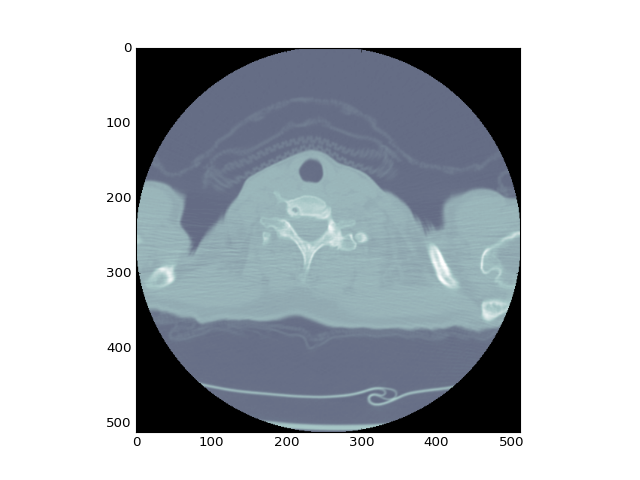

In [9]:
#from https://www.kaggle.com/z0mbie/data-science-bowl-2017/chest-cavity-animation-with-pacemaker
#not working..hmm
%matplotlib nbagg
import matplotlib.animation as animation
fig = plt.figure() # make figure
from IPython.display import HTML

im = plt.imshow(full_img[0], cmap=pylab.cm.bone)

# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(full_img[j])
    # return the artists set
    return im,
# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, frames=range(len(full_img)), 
                              interval=50, blit=True)
ani.save('Chest_Cavity.gif', writer='imagemagick')
plt.show()

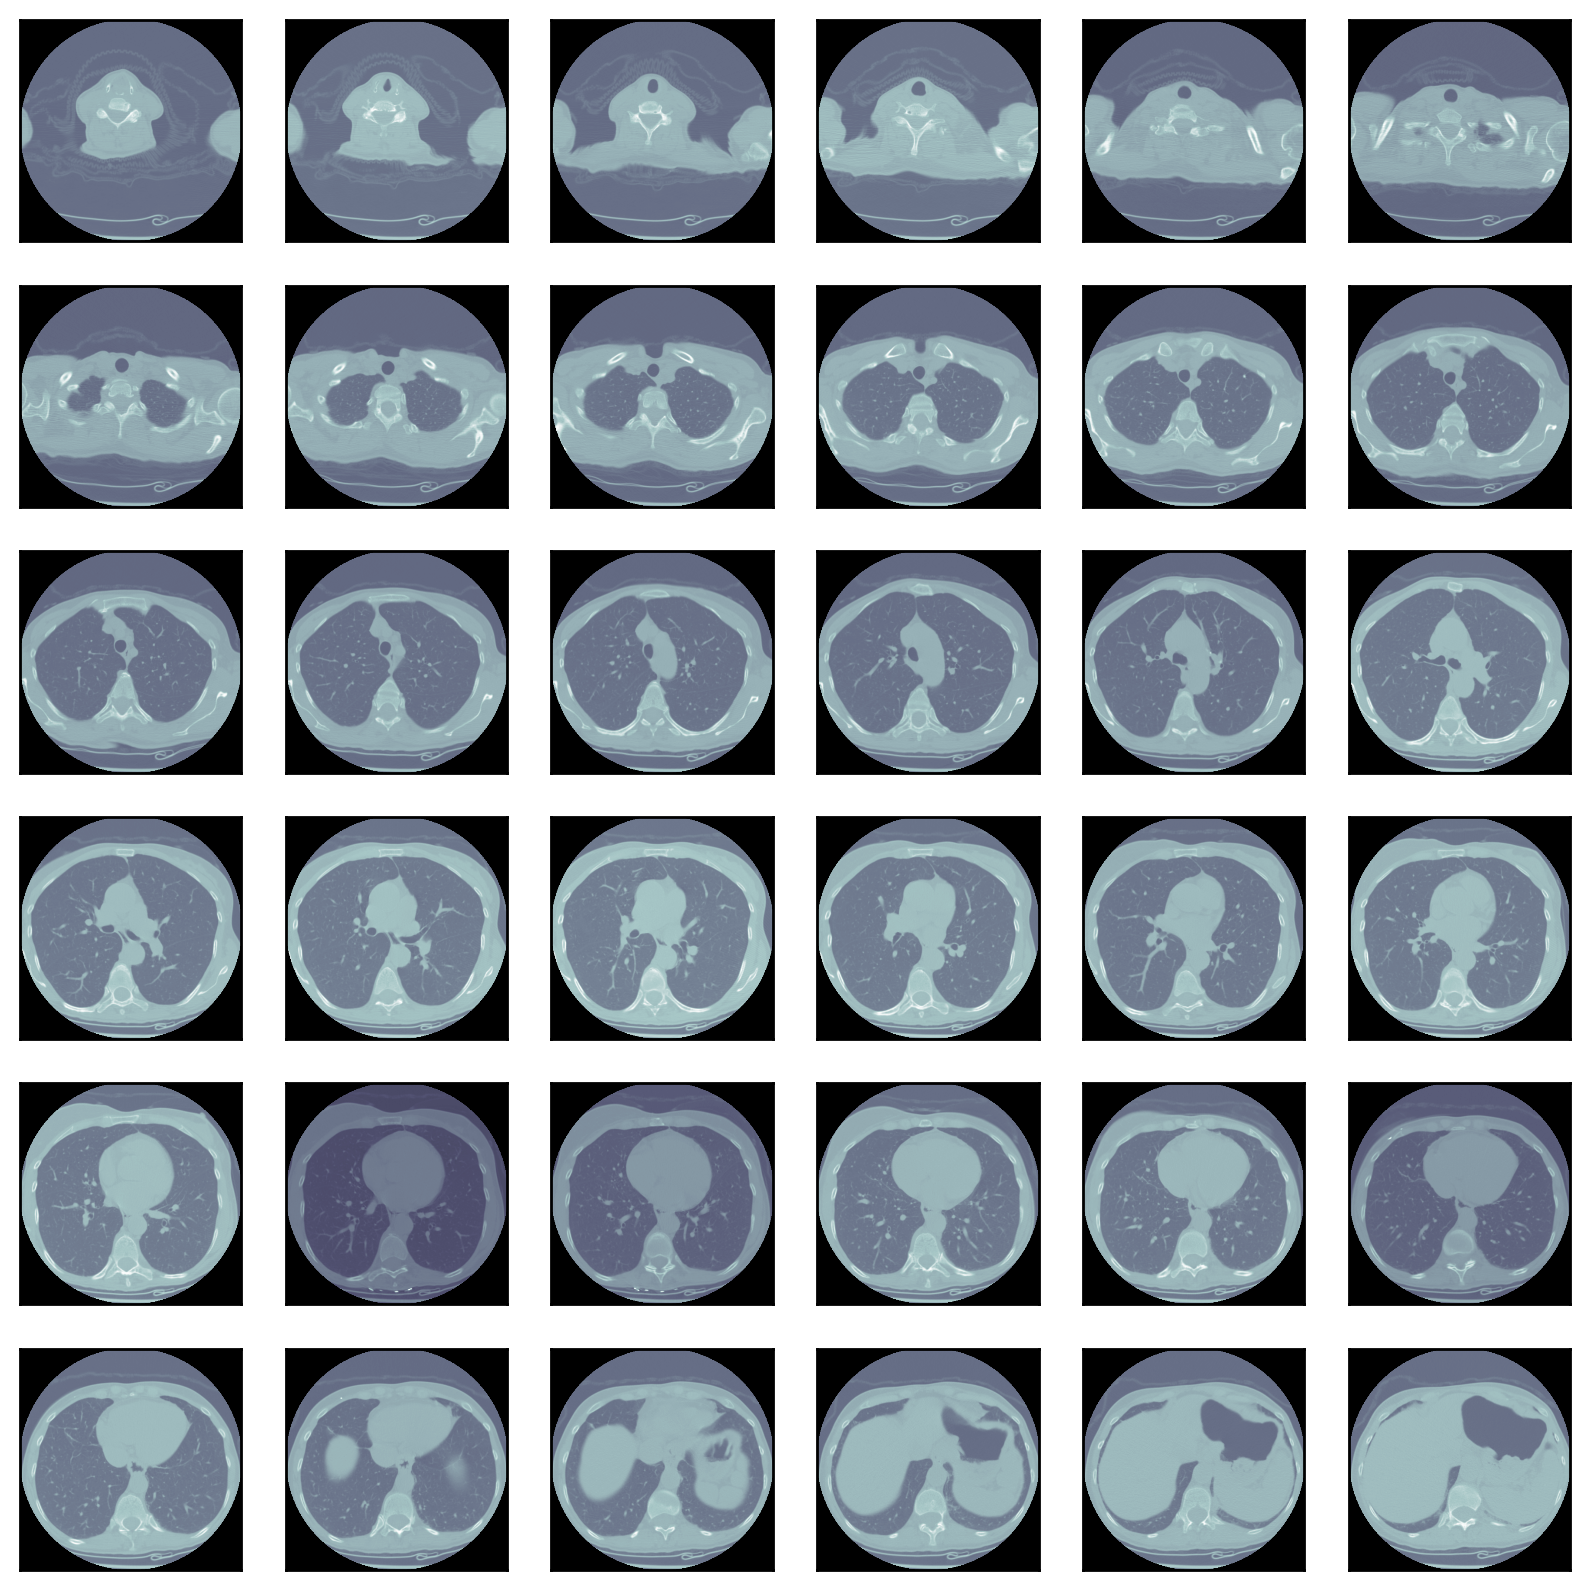

In [10]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)


for i in range(36):
    plt.subplot(6,6,i+1)
    show(full_img[4*i,:,:])    
    plt.xticks([])
    plt.yticks([])

### X-axis (frontal) sweep:

NameError: name 'cv2' is not defined

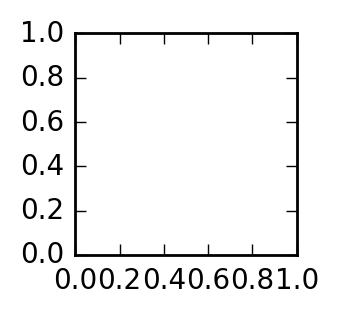

In [11]:
for i in range(36):
    plt.subplot(6,6,i+1)
    img = cv2.resize(full_img[:,20+ 12*i,:], (256, 256))
    show(img)    
    plt.xticks([])
    plt.yticks([])

### Y-axis (lateral) sweep:

In [ ]:
for i in range(36):
    plt.subplot(6,6,i+1)
    img = cv2.resize(full_img[:,:,20+ 12*i], (256, 256))
    show(img)    
    plt.xticks([])
    plt.yticks([])

Pretty fascinating stuff - in particular it's easy to see the 3 different perspectives. Another neat thing is that once we got the scans we managed to visualize them using very basic python open source tools - basically numpy and matplotlib. No need for fancy medical imaging tools.

I wish I could say something more interesting about these images but honestly I have no medical expertise whatsoever so I'll just stare at them for a bit and maybe read more on human anatomy :)

### Edge detection and other convolutional filters:

Since we're interested in detecting whether a patient will be diagnosed with lung cancer, we can try to see if we can detect pulmonary nodules using something like edge detection. This can be done using a sobel filter (aka hand crafted one-filter CNN). 

Let's also take a look at the distribution of the pixels values in an image first:

In [ ]:
full_img[100]

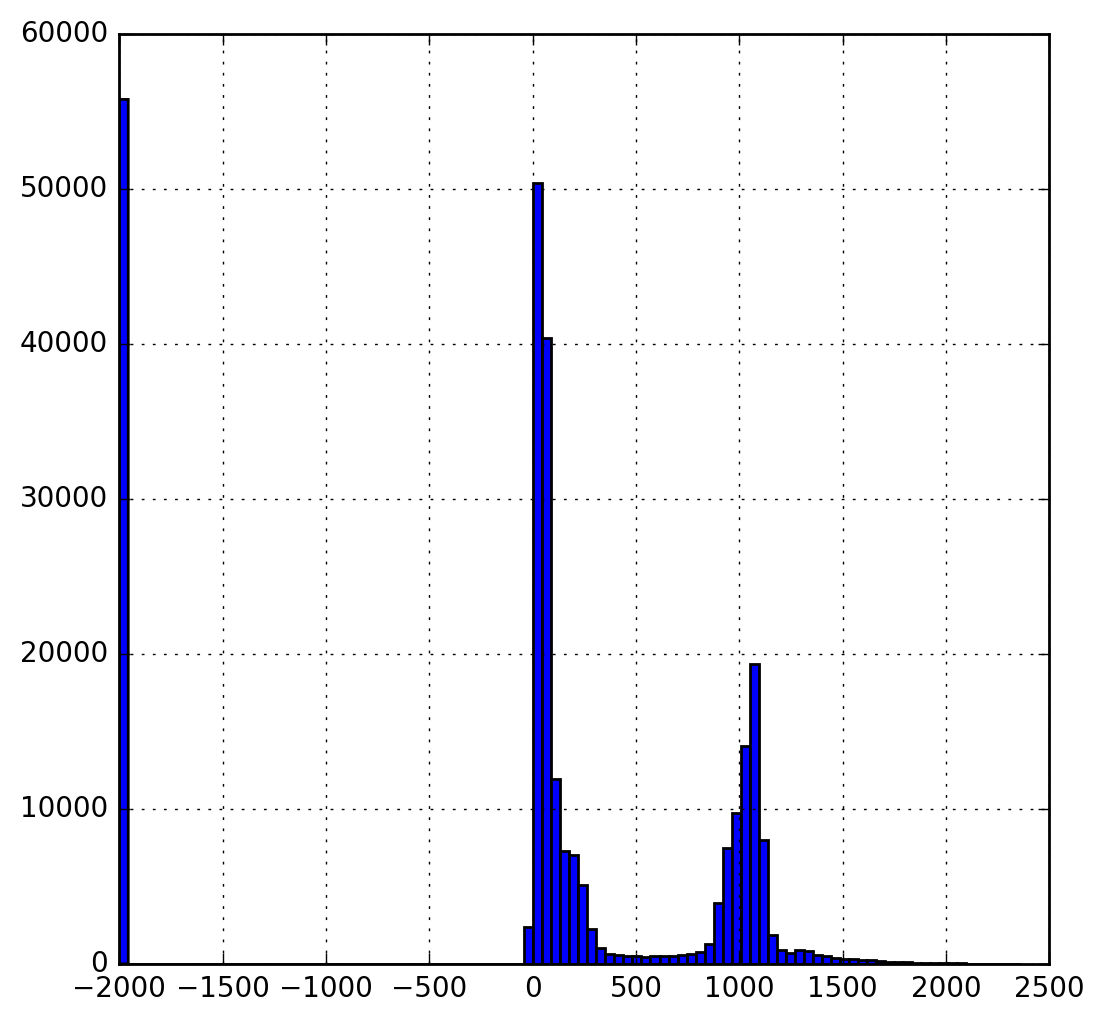

In [12]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
pd.Series(full_img[10].ravel()).hist(bins = 100)

Interesting - the distribution seems to be roughly bimodal with a bunch of pixels set at - 2000 - probably for missing values.

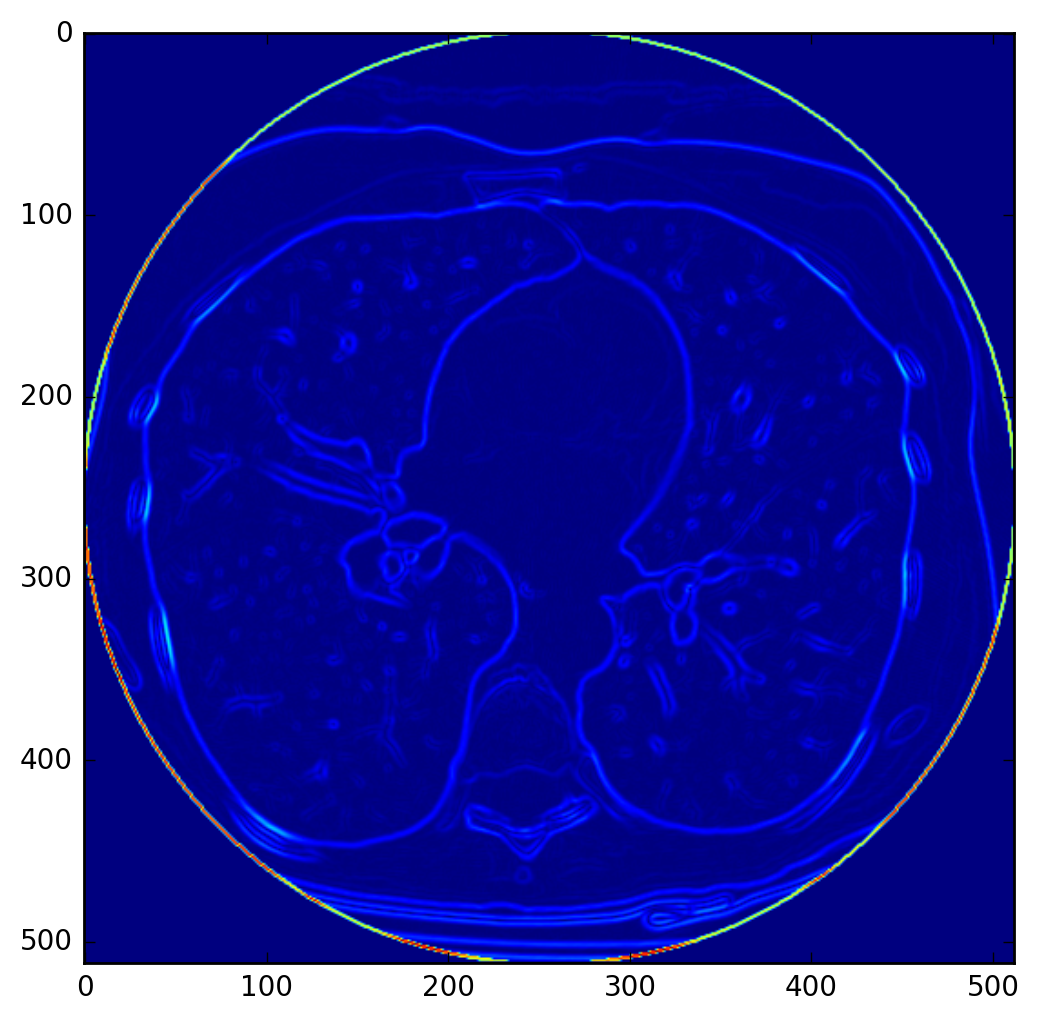

In [14]:
edge_img = filters.sobel(full_img[90,:,:]/2500)
plt.imshow(edge_img)

The Sobel filter does find the edges but the image is very low intensity. One thing we can do is to simply treshold the image to see the segmentation better:

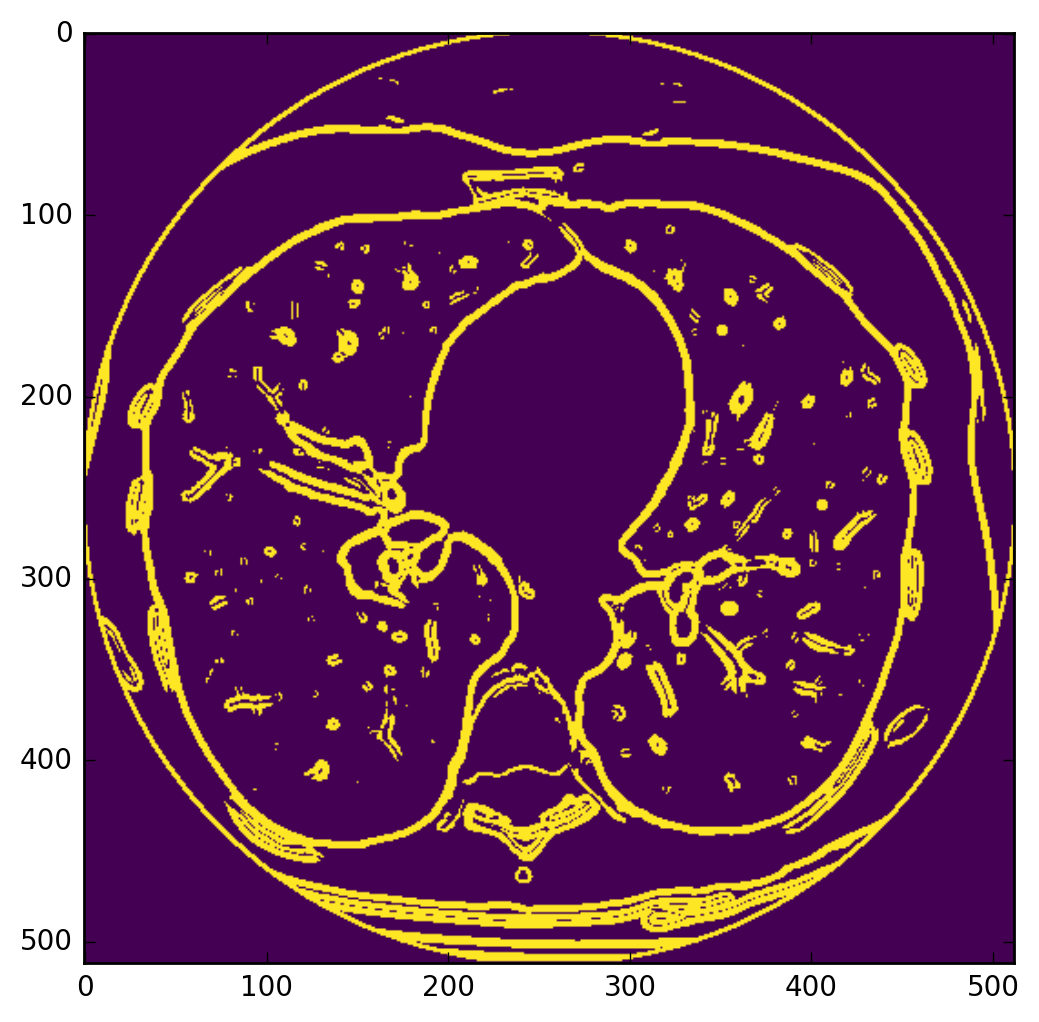

In [15]:
plt.imshow(edge_img > 0.04, cmap = "viridis")

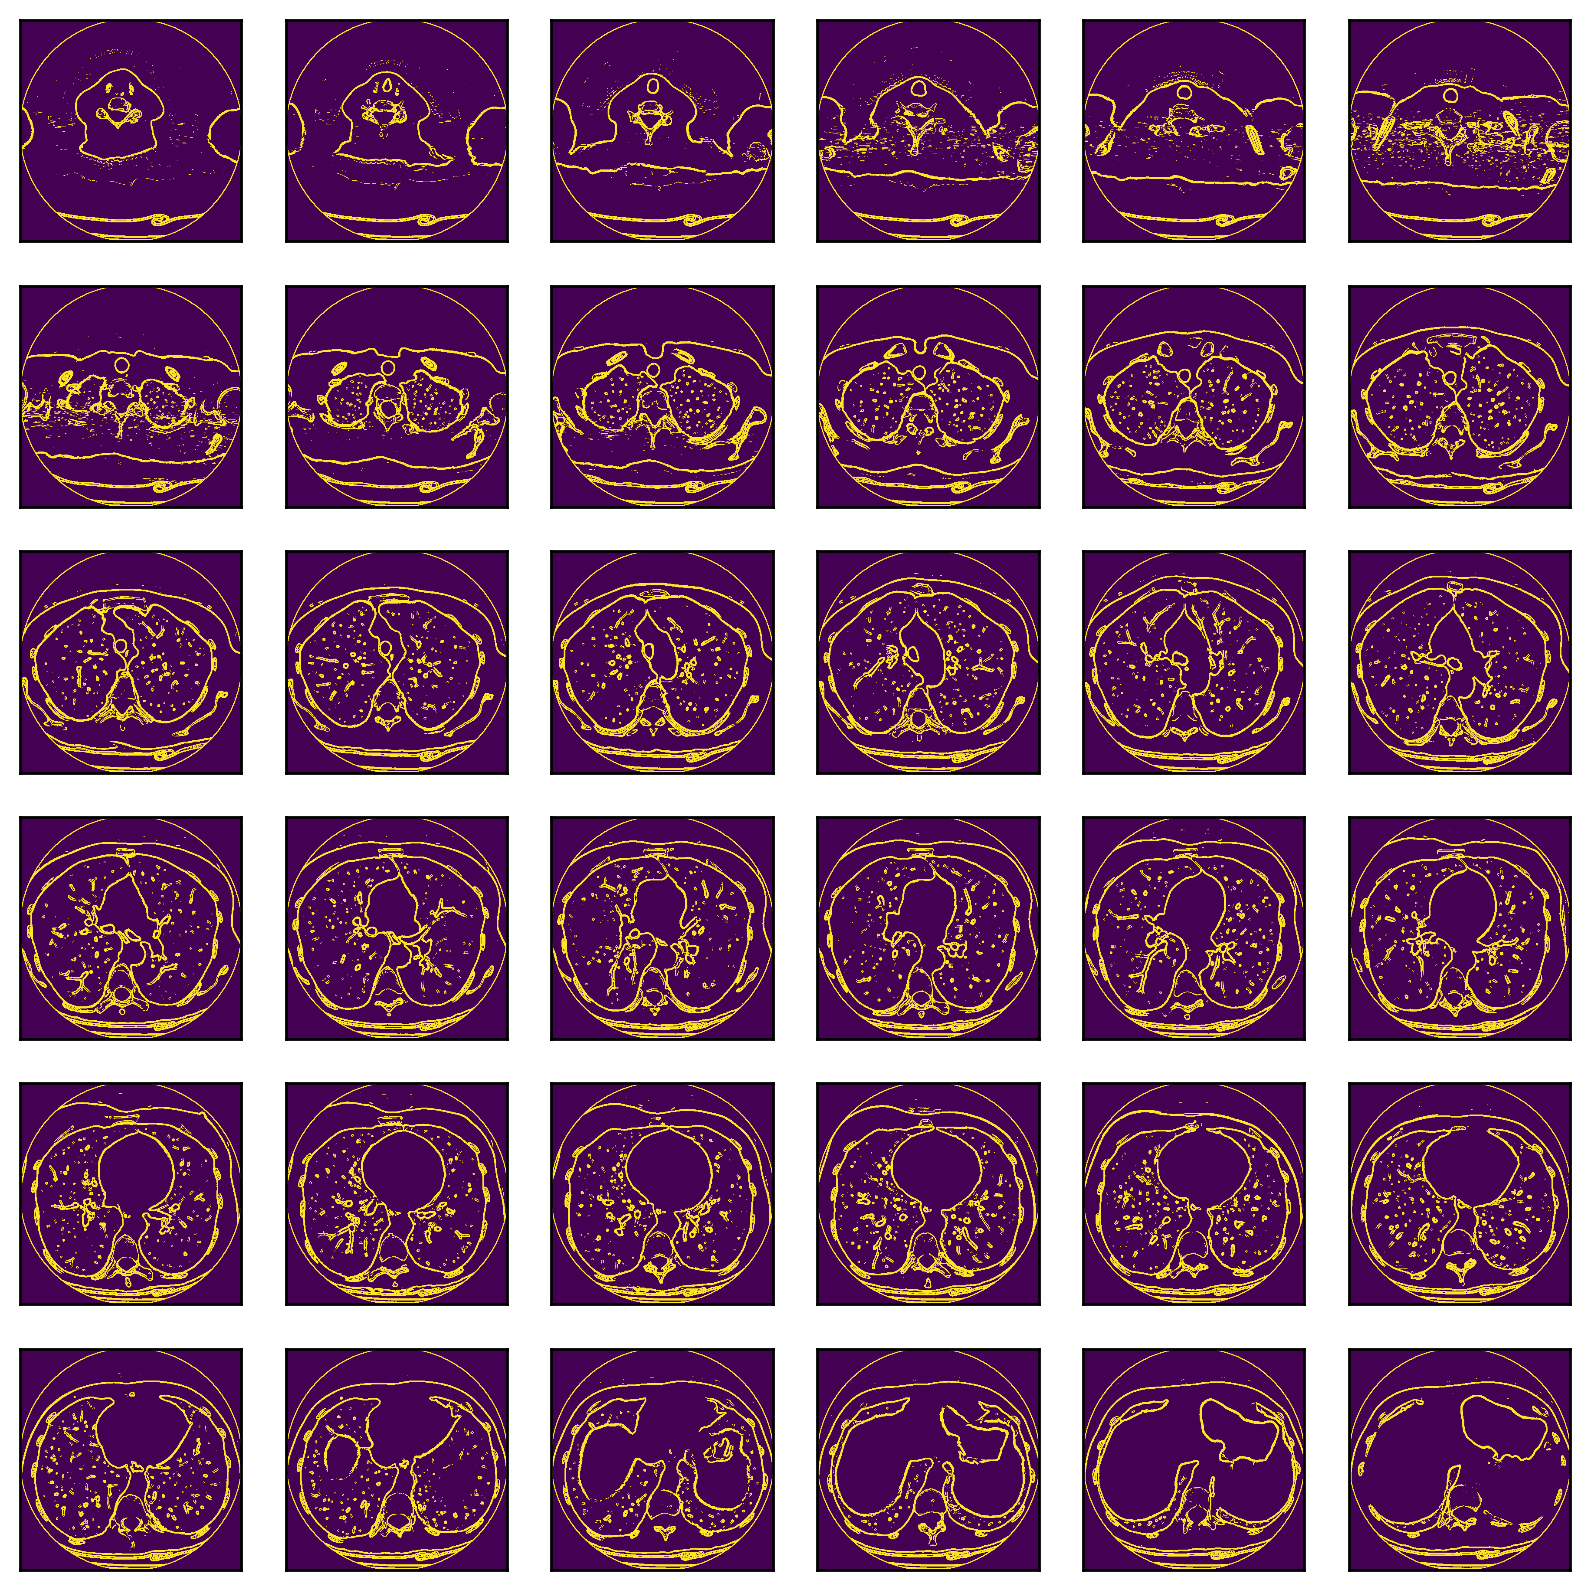

In [16]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)


for i in range(36):
    plt.subplot(6,6,i+1)
    edge_img = filters.sobel(full_img[4*i,:,:]/2500)
    img = edge_img > 0.04
    plt.imshow(img, cmap = "viridis")    
    plt.xticks([])
    plt.yticks([])

Interesting results, however the issue here is that the filter will also detect the blood vessels in the lung. So some sort of 3-D surface detection that differentiates between spheres and tubes would be more suitable for this situation.

### Future Ideas:

- creating a 3-D representation of the lungs
- try other filters
- analyze the metadata more closely.

Thanks for reading!